In [43]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import cv2
import os
import glob # Para listar archivos
from tqdm import tqdm
import matplotlib.pyplot as plt

# Librerías CRÍTICAS para la Segmentación (Albumentations)
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [44]:
# --- AJUSTAR ESTAS RUTAS Y CONSTANTES ---
# Asegúrate de que estas carpetas existan en tu entorno
TRAIN_IMAGES_DIR = 'train/images'
TRAIN_MASKS_DIR = 'train/masks'
BATCH_SIZE = 64

# Valores de Normalización Z-Score (Paso 2 del EDA)
MEAN = [0.515, 0.484, 0.460] 
STD = [0.314, 0.303, 0.303]
# ----------------------------------------

# Obtener la lista de todos los archivos (asumiendo que los nombres coinciden en imagen y máscara)
# Esto es esencial para el constructor del Dataset
all_files = os.listdir(TRAIN_IMAGES_DIR)
all_files = [f for f in all_files if f.endswith('.png') or f.endswith('.jpg')]

In [45]:
def get_transforms(phase, mean, std):
    
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(
                height=800, width=800, 
                scale=(0.5, 1.2),  # Desde 50% hasta 120% del tamaño
                ratio=(0.8, 1.2), p=0.5
            ),
            
            # Augmentation Geométrica (Invariancia a Posición/Forma)
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.1, rotate_limit=15, p=0.7),
            
            A.OneOf([
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.4),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.4),
            ], p=0.5),
            
            # Augmentation de Textura y Color
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=0.3),
                A.MotionBlur(blur_limit=(3, 7), p=0.3),
            ], p=0.4),
            
            A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.05, p=0.8),

            # Normalización
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
            ToTensorV2(), 
        ])
    
    else: 
        return A.Compose([
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
            ToTensorV2(),
        ])

In [46]:
class HumanSegmentationDataset(Dataset):
    """Clase base que carga datos como NumPy Arrays."""
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        # Asegura la lista de archivos base
        self.image_files = os.listdir(image_dir)
        self.image_files = [f for f in self.image_files if f.endswith(('.png', '.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        
        # Cargar imagen (RGB)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB (H, W, 3)
        
        # Cargar máscara (Grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (H, W)
        mask = (mask > 0).astype(np.float32) # Binarizar 0/1 (float32)

        # CRÍTICO: Devolver NumPy arrays SIN aplicar transformaciones
        return image, mask


class SubsetWrapper(Dataset): 
    """Aplica el transform específico (train o val) al Subset."""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # La llamada a self.subset[idx] usa el __getitem__ de HumanSegmentationDataset y devuelve NumPy arrays
        image_np, mask_np = self.subset[idx]
        
        # Aplicamos la transformación Sincronizada (Albumentations)
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_tensor = augmented['image'] # (3, H, W)
            mask_tensor = augmented['mask']   # (H, W)
            
            # Asegurar que la máscara tenga la dimensión de canal (1, H, W)
            if mask_tensor.ndim == 2:
                mask_tensor = mask_tensor.unsqueeze(0) 
            
            return image_tensor, mask_tensor
        
        # Si no hay transform (caso de emergencia, no debería ocurrir aquí)
        # Esto solo lo devolvería si transform es None
        return image_np, mask_np

In [47]:
def get_dataloaders(train_ratio=0.8, batch_size=BATCH_SIZE, num_workers=0):
    
    # 1. Crear el Dataset Base (sin transform)
    full_dataset = HumanSegmentationDataset(
        image_dir=TRAIN_IMAGES_DIR, 
        mask_dir=TRAIN_MASKS_DIR
    )

    # 2. Dividir el Dataset
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    # 3. Obtener los transforms específicos
    train_transforms = get_transforms('train', MEAN, STD)
    val_transforms = get_transforms('val', MEAN, STD)

    # 4. Envolver los Subsets para aplicar la Augmentation correcta
    train_dataset_final = SubsetWrapper(train_subset, train_transforms)
    val_dataset_final = SubsetWrapper(val_subset, val_transforms)

    # 5. Crear DataLoaders
    train_loader = DataLoader(
        train_dataset_final, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset_final, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True
    )
    
    print(f"✅ DataLoaders listos. Train: {len(train_dataset_final)} | Val: {len(val_dataset_final)}")
    return train_loader, val_loader

# --- EJECUTAR PARA OBTENER LOS LOADERS ---
train_loader, val_loader = get_dataloaders()

ValueError: 2 validation errors for InitSchema
scale
  Value error, All values in (0.5, 1.2) must be >= 0 and <= 1 [type=value_error, input_value=(0.5, 1.2), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error
size
  Field required [type=missing, input_value={'scale': (0.5, 1.2), 'ra...: None, 'strict': False}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing

In [48]:
def visualize_batch(data_loader, title="Batch de Imágenes", num_samples=4, mean=MEAN, std=STD, figsize=(6, 3)):
    """Extrae un batch y visualiza las imágenes y sus máscaras."""
    
    # 1. Extraer un batch
    images, masks = next(iter(data_loader))
    
    # Calcular tamaño final según num_samples y el factor base figsize
    fig_width, fig_height_base = figsize
    fig, axes = plt.subplots(num_samples, 2, figsize=(fig_width, fig_height_base * num_samples))
    fig.suptitle(title, fontsize=12)

    # 2. Desnormalización y Ploteo
    for i in range(min(num_samples, len(images))):
        img_tensor = images[i].cpu()
        mask_tensor = masks[i].cpu().squeeze(0) # Quitar la dimensión de canal (1, H, W) -> (H, W)

        # Desnormalizar la imagen: img = (img * std) + mean
        # Necesitamos iterar sobre los canales (C=0) para desnormalizar correctamente
        for t, m, s in zip(img_tensor, mean, std):
            t.mul_(s).add_(m)
        
        # PyTorch es C, H, W. Matplotlib espera H, W, C.
        img_np = img_tensor.permute(1, 2, 0).numpy()
        mask_np = mask_tensor.numpy()
        
        # Ploteo de Imagen
        axes[i, 0].imshow(img_np.clip(0, 1)) # clip(0, 1) para manejar los valores fuera del rango por la desnormalización
        axes[i, 0].set_title(f"Muestra {i}: Imagen", fontsize=9)
        axes[i, 0].axis('off')
        
        # Ploteo de Máscara
        axes[i, 1].imshow(mask_np, cmap='gray') # Usar escala de grises para la máscara binaria
        axes[i, 1].set_title(f"Muestra {i}: Máscara", fontsize=9)
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


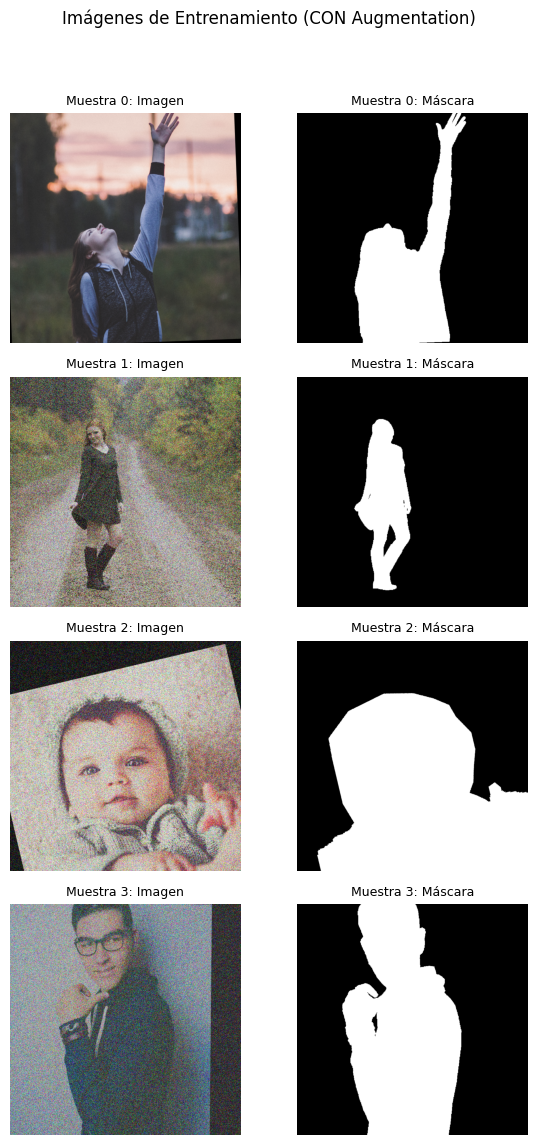

In [50]:
# Asegúrate de que train_loader esté disponible
visualize_batch(train_loader, "Imágenes de Entrenamiento (CON Augmentation)", num_samples=4)

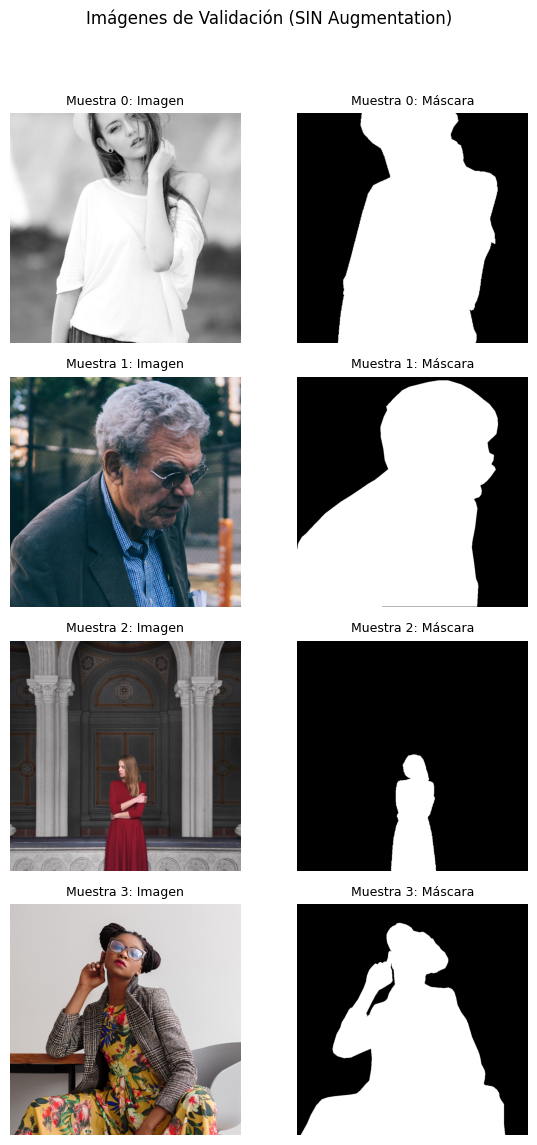

In [51]:
visualize_batch(val_loader, "Imágenes de Validación (SIN Augmentation)", num_samples=4)